In [2]:
# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import sklearn as sk
from sklearn import metrics

import gower # calcula matriz de distancias gower
import fastcluster # mejora la performance del cluster jerárquico

# https://genieclust.gagolewski.com/
# https://doi.org/10.1016/j.softx.2021.100722
import genieclust

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
import seaborn as sns
import time

# trabajo con zip
from zipfile import ZipFile
from io import BytesIO


# from google.colab import drive
# drive.mount('/content/drive')

In [3]:

def grafico_evaluacion(X_train_test, labels_orig, labels_test , nom_test=''):
    '''grafico en el espacio vectorial del pca las clasificaciones realizadas
    X_train_test = coordenadas de lso puntos en PCA -considera slo las primeras 4-
    labels_orig  = etiquetas originales - reales
    labels_test  = etiquetas halladeas por el algoritmo
    nom_test     = texto para aclara en el grafico el nombre del clasificador utilizado
    '''
    fig, axs = plt.subplots(2,2)
    axs[0,0].scatter(X_train_test[:,0],X_train_test[:,1],s=5,c=labels_test, alpha=0.5)
    axs[0,0].set_xlabel('PC1')
    axs[0,0].set_ylabel('PC2')
    axs[0,1].scatter(X_train_test[:,2],X_train_test[:,3],s=5,c=labels_test, alpha=0.5)
    axs[0,1].set_xlabel('PC3')
    axs[0,1].set_ylabel('PC4')
    
    
    axs[1,0].scatter(X_train_test[:,0],X_train_test[:,1],s=5,c=labels_orig, alpha=0.5)
    axs[1,0].set_xlabel('PC1')
    axs[1,0].set_ylabel('PC2')
    axs[1,1].scatter(X_train_test[:,2],X_train_test[:,3],s=5,c=labels_orig, alpha=0.5)
    axs[1,1].set_xlabel('PC3')
    axs[1,1].set_ylabel('PC4')
    
    
    axs[0,0].set_title(f'{nom_test}')
    axs[0,1].set_title(f'{nom_test}')
    axs[1,0].set_title('real')
    axs[1,1].set_title('real')
    fig.set_constrained_layout('constrained')
    return None

def cross_tab(Labels_orig, Labels_clust):
    '''crea matriz de confusión para evaluar etiquetado
    labels_orig  = etiquetas originales - reales
    labels_test  = etiquetas halladeas por el algoritmo'''
    tmp = pd.DataFrame({'Labels_orig': Labels_orig, 'Labels_clust': Labels_clust})
    ct = pd.crosstab(tmp['Labels_clust'],tmp['Labels_orig']) # Create crosstab: ct
    rand = metrics.rand_score(Labels_orig, Labels_clust)
    arand= metrics.adjusted_rand_score(Labels_orig, Labels_clust)
    print(f'RAND score={rand:.4f}, Ajusted RAND={arand:.4f}')
    return ct


In [5]:
# cargo los archivos de donde los dejé del paso anterior y los paso a pca

df1 = pd.read_csv('C:/Users/jfgonzalez/Documents/Documentación_maestría/Ciencia_y_tecnologia/unsupervised-rice-image-segmentation/input/features_Arborio.csv')
df2 = pd.read_csv('C:/Users/jfgonzalez/Documents/Documentación_maestría/Ciencia_y_tecnologia/unsupervised-rice-image-segmentation/input/features_Basmati.csv')
df3 = pd.read_csv('C:/Users/jfgonzalez/Documents/Documentación_maestría/Ciencia_y_tecnologia/unsupervised-rice-image-segmentation/input/features_Ipsala.csv')
df4 = pd.read_csv('C:/Users/jfgonzalez/Documents/Documentación_maestría/Ciencia_y_tecnologia/unsupervised-rice-image-segmentation/input/features_Jasmine.csv')
df5 = pd.read_csv('C:/Users/jfgonzalez/Documents/Documentación_maestría/Ciencia_y_tecnologia/unsupervised-rice-image-segmentation/input/features_Karacadag.csv')
features = np.array(pd.concat([df1,df2,df3,df4,df5], axis =0))
del df1,df2,df3,df4,df5

# como están ordenadas por clase voy a hacer una lista con las etiquetas ahora antes de mezclarlas
clases_dict = {0:'Arborio', 1:'Basmati', 2:'Ipsala', 3:'Jasmine', 4:'Karacadag'}
lista_clases = ([0]*15000 + [1]*15000 + [2]*15000 + [3]*15000 + [4]*15000)

# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=100, random_state=22)
pca.fit(features)
x = pca.transform(features)

del features

Text(0, 0.5, 'Var. explicada (%)')

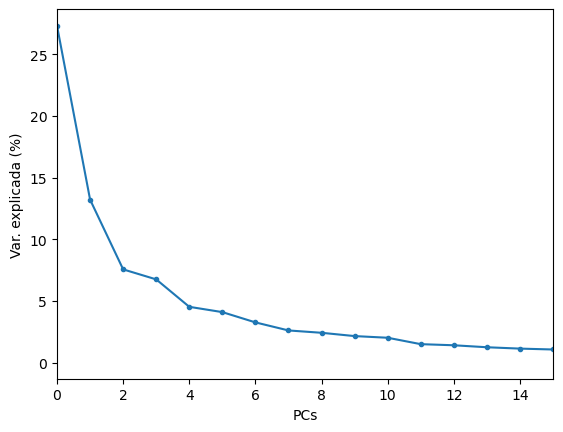

In [6]:
#%% ploteo
ax = plt.subplot()
ax.plot(100*pca.explained_variance_ / sum(pca.explained_variance_),'.-')
ax.set_xlim([0,15])
ax.set_xlabel('PCs')
ax.set_ylabel('Var. explicada (%)')

In [7]:
# divido dataset hay que considerar el tamaño según el método porque algunos toman mucho tiempo

# separo en train_test y validación con sus respectivas etiquetas y los mezclo
X_train_test, X_val, y_train_test, y_val = sk.model_selection.train_test_split(x, lista_clases, test_size=0.5, random_state=42)


RAND score=0.8132, Ajusted RAND=0.4194


Labels_orig,0,1,2,3,4
Labels_clust,,,,,
0,773,0,41,4,7096
1,11,4639,4,1183,0
2,3685,4,3914,347,107
3,2979,18,3303,1827,334
4,80,2921,64,4166,0


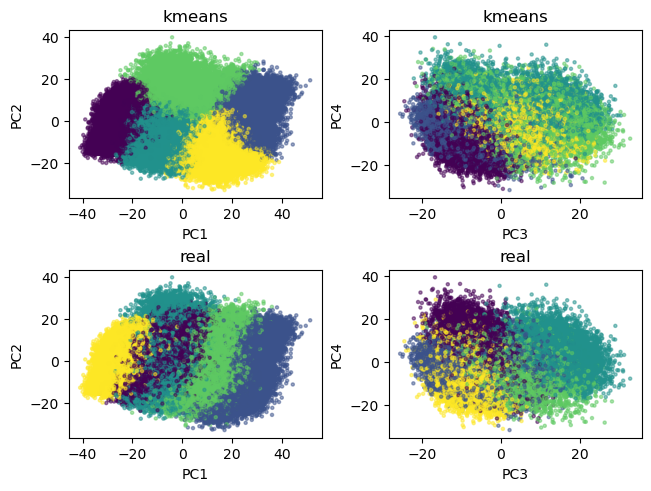

In [8]:
# aplico kmeans, esto porque es rápido y me sirve de punto de comparación


#kmeans = KMeans(n_clusters=len(unique_labels))
kmeans = KMeans(n_clusters=5, n_init='auto')
kmeans.fit(X_train_test)


grafico_evaluacion(X_train_test, y_train_test, kmeans.labels_ , nom_test='kmeans')
cross_tab(y_train_test, kmeans.labels_)


RAND score=0.8200, Ajusted RAND=0.5368


Labels_orig,0,1,2,3,4
Labels_clust,,,,,
0,54,5852,45,7413,0
1,7468,0,112,27,7537
2,2,0,2068,12,0
3,4,0,5100,54,0
4,0,1730,1,21,0


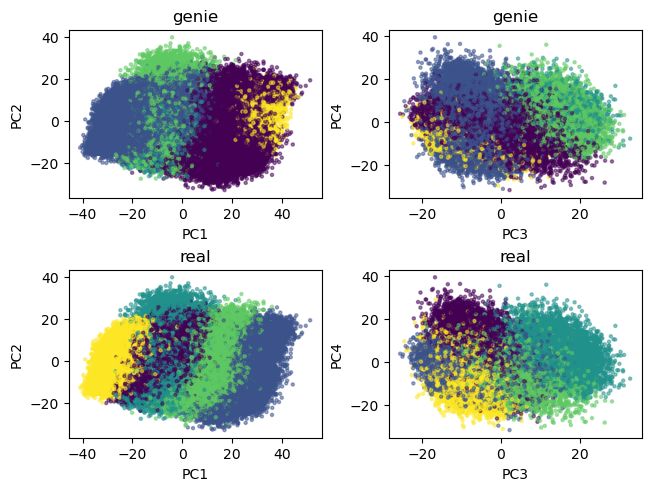

In [9]:
# aplico genieclust (mejora la clasificación con más datos)

g = genieclust.Genie(n_clusters=5)
labels_genie = g.fit_predict(X_train_test)


grafico_evaluacion(X_train_test, y_train_test, labels_genie , nom_test='genie')
cross_tab(y_train_test, labels_genie)

In [8]:
# calculo distancias gower
# TARDA MUCHO, OJO CON LA CANTIDAD DE DATOS

#armo matriz de distancias
# en colab cuelga por falta de ram, local funciona
d_meta = gower.gower_matrix(X_train_test)

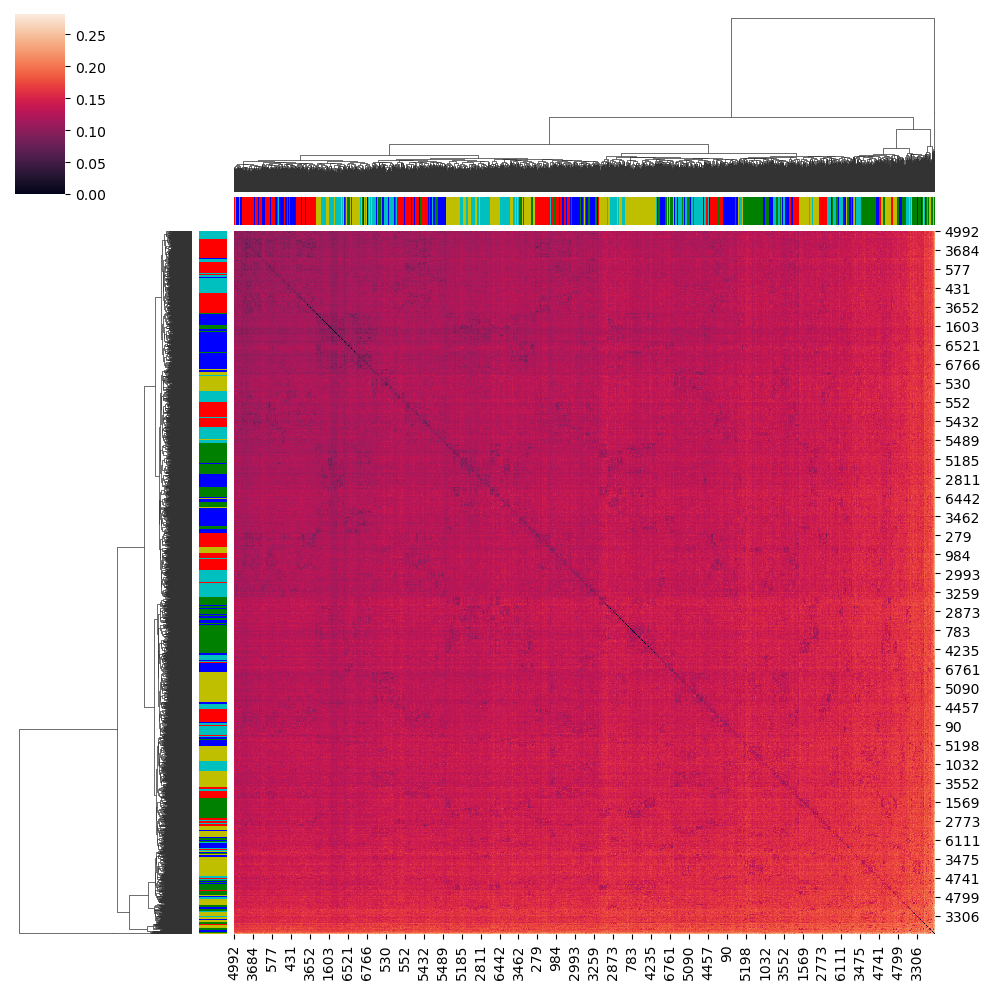

In [9]:
# grafico cluster jerarquico

#esto son colores para ver como comparan estos clusters con los que teníamos armados antes
xval = pd.Series(y_train_test)
lut = dict(zip(xval.unique(), "rbgyc"))
row_colors = xval.map(lut).to_numpy()

xval = pd.Series(kmeans.labels_)
lut = dict(zip(xval.unique(), "rbgyc"))
col_colors = xval.map(lut).to_numpy()

#este paso también TARDA MUCHO porque hace el cluterizado en el gráfico...
mapa_clust = sns.clustermap(d_meta, row_colors=row_colors, col_colors=col_colors)